# First approach, simple neural networks

In [14]:
import pickle
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from dataset import LinkPredictionDataset
from evaluation import load_model, evaluate_all_metrics
from graph import *
from models import MyPredictionModel, EdgePredictionModel, GraphPredictionModel
from node import *

warnings.simplefilter("ignore", category=FutureWarning)


In [25]:
with open('./data/graphs.dat', 'rb') as file:
    graphs_list: List[Graph] = pickle.load(file)
    train_graphs_list, temp_graphs = train_test_split(graphs_list, test_size=0.2, random_state=42)
    val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)
   
print(f"Dataset size: {len(graphs_list)}")    
print(f"Train set size: {len(train_graphs_list)}")
print(f"Validation set size: {len(val_graphs)}")
print(f"Test set size: {len(test_graphs)}")

all_part_ids = []
all_family_ids = []
for graph in train_graphs_list:
    for n in graph.get_nodes():
        all_part_ids.append(int(n.get_part().get_part_id()))
        all_family_ids.append(int(n.get_part().get_family_id()))

part_vocab_size = max(all_part_ids) + 1
family_vocab_size = max(all_family_ids) + 1
print(f"Part Vocab Size: {part_vocab_size}")
print(f"Family Vocab Size: {family_vocab_size}")

Dataset size: 11159
Train set size: 8927
Validation set size: 1116
Test set size: 1116
Part Vocab Size: 2271
Family Vocab Size: 96


In [16]:
def train_edge_predictor(model, train_dataloader, val_dataloader, optimizer, criterion, epochs=100):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs), desc="Training", unit="epoch"):
        # Training phase
        model.train()
        total_train_loss = 0.0

        for batch in train_dataloader:
            part_i, fam_i, part_j, fam_j, label = batch

            # Convert data to correct types
            part_i = part_i.long()
            fam_i = fam_i.long()
            part_j = part_j.long()
            fam_j = fam_j.long()
            label = label.float()

            optimizer.zero_grad()
            logits = model(part_i, fam_i, part_j, fam_j)
            loss = criterion(logits, label)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                part_i, fam_i, part_j, fam_j, label = batch

                part_i = part_i.long()
                fam_i = fam_i.long()
                part_j = part_j.long()
                fam_j = fam_j.long()
                label = label.float()

                logits = model(part_i, fam_i, part_j, fam_j)
                val_loss = criterion(logits, label)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


### Now train it and write it to disk

In [17]:
# Create datasets for train and validation
train_dataset = LinkPredictionDataset(train_graphs_list)
val_dataset = LinkPredictionDataset(val_graphs)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the model, criterion, and optimizer
model_EdgePredictor = EdgePredictionModel(part_vocab_size, family_vocab_size, embed_dim=16, hidden_dim=32)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_EdgePredictor.parameters(), lr=0.001)

# Train the model with training and validation data
train_losses, val_losses = train_edge_predictor(
    model_EdgePredictor, train_dataloader, val_dataloader, optimizer, criterion, epochs=50
)

# Save the trained model
torch.save(model_EdgePredictor.state_dict(), "edge_predictor_model.pth")


Training:   2%|▏         | 1/50 [00:05<04:45,  5.82s/epoch]

Epoch 1/50 - Train Loss: 0.1511, Val Loss: 0.0976


Training:   4%|▍         | 2/50 [00:12<05:05,  6.36s/epoch]

Epoch 2/50 - Train Loss: 0.0901, Val Loss: 0.0899


Training:   6%|▌         | 3/50 [00:17<04:28,  5.71s/epoch]

Epoch 3/50 - Train Loss: 0.0847, Val Loss: 0.0851


Training:   8%|▊         | 4/50 [00:22<04:12,  5.49s/epoch]

Epoch 4/50 - Train Loss: 0.0825, Val Loss: 0.0834


Training:  10%|█         | 5/50 [00:28<04:19,  5.77s/epoch]

Epoch 5/50 - Train Loss: 0.0810, Val Loss: 0.0838


Training:  12%|█▏        | 6/50 [00:33<03:55,  5.35s/epoch]

Epoch 6/50 - Train Loss: 0.0800, Val Loss: 0.0826


Training:  14%|█▍        | 7/50 [00:38<03:44,  5.22s/epoch]

Epoch 7/50 - Train Loss: 0.0794, Val Loss: 0.0832


Training:  16%|█▌        | 8/50 [00:44<03:50,  5.50s/epoch]

Epoch 8/50 - Train Loss: 0.0788, Val Loss: 0.0809


Training:  18%|█▊        | 9/50 [00:49<03:42,  5.43s/epoch]

Epoch 9/50 - Train Loss: 0.0783, Val Loss: 0.0809


Training:  20%|██        | 10/50 [00:57<04:06,  6.17s/epoch]

Epoch 10/50 - Train Loss: 0.0780, Val Loss: 0.0796


Training:  22%|██▏       | 11/50 [01:02<03:51,  5.93s/epoch]

Epoch 11/50 - Train Loss: 0.0775, Val Loss: 0.0805


Training:  24%|██▍       | 12/50 [01:08<03:35,  5.67s/epoch]

Epoch 12/50 - Train Loss: 0.0773, Val Loss: 0.0799


Training:  26%|██▌       | 13/50 [01:13<03:31,  5.71s/epoch]

Epoch 13/50 - Train Loss: 0.0771, Val Loss: 0.0795


Training:  28%|██▊       | 14/50 [01:17<03:07,  5.21s/epoch]

Epoch 14/50 - Train Loss: 0.0769, Val Loss: 0.0801


Training:  30%|███       | 15/50 [01:21<02:50,  4.86s/epoch]

Epoch 15/50 - Train Loss: 0.0767, Val Loss: 0.0789


Training:  32%|███▏      | 16/50 [01:26<02:36,  4.62s/epoch]

Epoch 16/50 - Train Loss: 0.0765, Val Loss: 0.0792


Training:  34%|███▍      | 17/50 [01:30<02:26,  4.44s/epoch]

Epoch 17/50 - Train Loss: 0.0764, Val Loss: 0.0788


Training:  36%|███▌      | 18/50 [01:34<02:17,  4.30s/epoch]

Epoch 18/50 - Train Loss: 0.0762, Val Loss: 0.0785


Training:  38%|███▊      | 19/50 [01:38<02:11,  4.24s/epoch]

Epoch 19/50 - Train Loss: 0.0761, Val Loss: 0.0787


Training:  40%|████      | 20/50 [01:42<02:05,  4.19s/epoch]

Epoch 20/50 - Train Loss: 0.0760, Val Loss: 0.0780


Training:  42%|████▏     | 21/50 [01:46<02:01,  4.18s/epoch]

Epoch 21/50 - Train Loss: 0.0759, Val Loss: 0.0793


Training:  44%|████▍     | 22/50 [01:50<01:57,  4.20s/epoch]

Epoch 22/50 - Train Loss: 0.0758, Val Loss: 0.0779


Training:  46%|████▌     | 23/50 [01:54<01:51,  4.14s/epoch]

Epoch 23/50 - Train Loss: 0.0757, Val Loss: 0.0788


Training:  48%|████▊     | 24/50 [01:58<01:46,  4.08s/epoch]

Epoch 24/50 - Train Loss: 0.0755, Val Loss: 0.0784


Training:  50%|█████     | 25/50 [02:02<01:42,  4.09s/epoch]

Epoch 25/50 - Train Loss: 0.0754, Val Loss: 0.0784


Training:  52%|█████▏    | 26/50 [02:06<01:37,  4.08s/epoch]

Epoch 26/50 - Train Loss: 0.0754, Val Loss: 0.0784


Training:  54%|█████▍    | 27/50 [02:10<01:33,  4.08s/epoch]

Epoch 27/50 - Train Loss: 0.0752, Val Loss: 0.0782


Training:  56%|█████▌    | 28/50 [02:14<01:28,  4.03s/epoch]

Epoch 28/50 - Train Loss: 0.0753, Val Loss: 0.0779


Training:  58%|█████▊    | 29/50 [02:18<01:23,  3.99s/epoch]

Epoch 29/50 - Train Loss: 0.0751, Val Loss: 0.0778


Training:  60%|██████    | 30/50 [02:22<01:19,  3.97s/epoch]

Epoch 30/50 - Train Loss: 0.0751, Val Loss: 0.0779


Training:  62%|██████▏   | 31/50 [02:26<01:16,  4.05s/epoch]

Epoch 31/50 - Train Loss: 0.0750, Val Loss: 0.0781


Training:  64%|██████▍   | 32/50 [02:30<01:12,  4.03s/epoch]

Epoch 32/50 - Train Loss: 0.0750, Val Loss: 0.0780


Training:  66%|██████▌   | 33/50 [02:34<01:07,  4.00s/epoch]

Epoch 33/50 - Train Loss: 0.0750, Val Loss: 0.0779


Training:  68%|██████▊   | 34/50 [02:38<01:04,  4.02s/epoch]

Epoch 34/50 - Train Loss: 0.0748, Val Loss: 0.0781


Training:  70%|███████   | 35/50 [02:42<01:00,  4.03s/epoch]

Epoch 35/50 - Train Loss: 0.0749, Val Loss: 0.0781


Training:  72%|███████▏  | 36/50 [02:46<00:56,  4.06s/epoch]

Epoch 36/50 - Train Loss: 0.0747, Val Loss: 0.0785


Training:  74%|███████▍  | 37/50 [02:50<00:52,  4.06s/epoch]

Epoch 37/50 - Train Loss: 0.0747, Val Loss: 0.0784


Training:  76%|███████▌  | 38/50 [02:55<00:48,  4.07s/epoch]

Epoch 38/50 - Train Loss: 0.0746, Val Loss: 0.0781


Training:  78%|███████▊  | 39/50 [02:59<00:44,  4.06s/epoch]

Epoch 39/50 - Train Loss: 0.0746, Val Loss: 0.0789


Training:  80%|████████  | 40/50 [03:03<00:40,  4.07s/epoch]

Epoch 40/50 - Train Loss: 0.0745, Val Loss: 0.0782


Training:  82%|████████▏ | 41/50 [03:07<00:36,  4.04s/epoch]

Epoch 41/50 - Train Loss: 0.0745, Val Loss: 0.0782


Training:  84%|████████▍ | 42/50 [03:11<00:32,  4.00s/epoch]

Epoch 42/50 - Train Loss: 0.0745, Val Loss: 0.0789


Training:  86%|████████▌ | 43/50 [03:15<00:27,  3.99s/epoch]

Epoch 43/50 - Train Loss: 0.0745, Val Loss: 0.0777


Training:  88%|████████▊ | 44/50 [03:19<00:24,  4.01s/epoch]

Epoch 44/50 - Train Loss: 0.0744, Val Loss: 0.0775


Training:  90%|█████████ | 45/50 [03:23<00:20,  4.03s/epoch]

Epoch 45/50 - Train Loss: 0.0744, Val Loss: 0.0783


Training:  92%|█████████▏| 46/50 [03:27<00:16,  4.06s/epoch]

Epoch 46/50 - Train Loss: 0.0744, Val Loss: 0.0781


Training:  94%|█████████▍| 47/50 [03:31<00:12,  4.10s/epoch]

Epoch 47/50 - Train Loss: 0.0743, Val Loss: 0.0778


Training:  96%|█████████▌| 48/50 [03:35<00:08,  4.13s/epoch]

Epoch 48/50 - Train Loss: 0.0743, Val Loss: 0.0781


Training:  98%|█████████▊| 49/50 [03:39<00:04,  4.11s/epoch]

Epoch 49/50 - Train Loss: 0.0743, Val Loss: 0.0775


Training: 100%|██████████| 50/50 [03:43<00:00,  4.48s/epoch]

Epoch 50/50 - Train Loss: 0.0742, Val Loss: 0.0777


### Visualization of training process
We can plot the train loss against the validation loss over the training epochs.

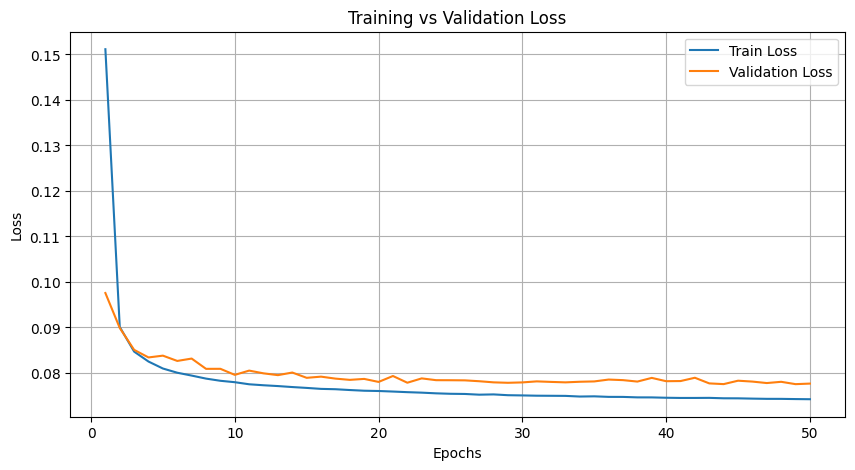

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


Now evaluate it
We developed our own metrics:

Evaluation Metrics:

1. Precision, Recall, F1-score:
   - Precision: Measures the proportion of correctly predicted edges out of all predicted edges.
   - Recall: Measures the proportion of correctly predicted edges out of all actual edges.
   - F1-score: Harmonic mean of precision and recall, balancing both metrics.

2. Hamming Distance:
   - Counts the number of differing edges between the predicted and target adjacency matrices.

3. Jaccard Similarity:
   - Measures the overlap between predicted and actual edge sets, calculated as the intersection over the union.

4. Graph Edit Distance:
   - Computes the minimum number of edge insertions, deletions, or substitutions to transform the predicted graph into the target graph.



We took the mean over all test samples.



In [21]:
model_file_path = 'edge_predictor_model.pth'
prediction_model: MyPredictionModel = load_model(model_file_path)

In [27]:
instances = [(graph.get_parts(), graph) for graph in test_graphs]
evaluate_all_metrics(prediction_model, instances)

Processing graphs:  14%|█▎        | 152/1116 [26:30<2:48:06, 10.46s/graph, failed=0, P=0.8798, R=0.9991, F1=0.9291, Hamming=1.4211, Jaccard=0.8794, Edit Dist=1.4211, Acc=96.35%]


KeyboardInterrupt: 

# Second Method: GNN

In [9]:
def train_graph_predictor(model, train_graphs_list, val_graphs_list, optimizer, criterion, epochs=100):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs), desc="Training", unit="epoch", total=epochs):
        model.train()
        total_train_loss = 0.0

        for graph in train_graphs_list:
            optimizer.zero_grad()

            # Sort nodes
            nodes = sorted(
                graph.get_nodes(),
                key=lambda node: (node.get_part().get_part_id(), node.get_part().get_family_id())
            )

            # Prepare part/family IDs
            part_ids = torch.tensor(
                [int(node.get_part().get_part_id()) for node in nodes],
                dtype=torch.long
            )
            family_ids = torch.tensor(
                [int(node.get_part().get_family_id()) for node in nodes],
                dtype=torch.long
            )

            # Build adjacency on the same device
            part_order = tuple(node.get_part() for node in nodes)
            adjacency_matrix = torch.tensor(
                graph.get_adjacency_matrix(part_order),
                dtype=torch.float32
            )

            # Forward pass
            logits = model(part_ids, family_ids)

            # Flatten for loss
            target = adjacency_matrix.flatten()
            loss = criterion(logits.flatten(), target)

            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_graphs_list)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for graph in val_graphs_list:
                nodes = sorted(
                    graph.get_nodes(),
                    key=lambda node: (node.get_part().get_part_id(), node.get_part().get_family_id())
                )

                part_ids = torch.tensor(
                    [int(node.get_part().get_part_id()) for node in nodes],
                    dtype=torch.long
                )
                family_ids = torch.tensor(
                    [int(node.get_part().get_family_id()) for node in nodes],
                    dtype=torch.long
                )

                part_order = tuple(node.get_part() for node in nodes)
                adjacency_matrix = torch.tensor(
                    graph.get_adjacency_matrix(part_order),
                    dtype=torch.float32
                )

                logits = model(part_ids, family_ids)
                target = adjacency_matrix.flatten()
                val_loss = criterion(logits.flatten(), target)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_graphs_list)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


### Now train it and write it to disk

In [10]:
model = GraphPredictionModel(part_vocab_size, family_vocab_size, embed_dim=1, gnn_hidden_dim=32)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

train_losses, val_losses = train_graph_predictor(model, train_graphs_list, val_graphs, optimizer, criterion, epochs=100)
torch.save(model.state_dict(), "graph_predictor_model.pth")



Training:   1%|          | 1/100 [00:06<10:57,  6.64s/epoch]

Epoch 1/100 - Train Loss: 0.2751, Val Loss: 0.1962


Training:   2%|▏         | 2/100 [00:12<10:03,  6.16s/epoch]

Epoch 2/100 - Train Loss: 0.1701, Val Loss: 0.1577


Training:   3%|▎         | 3/100 [00:18<09:47,  6.05s/epoch]

Epoch 3/100 - Train Loss: 0.1419, Val Loss: 0.1399


Training:   4%|▍         | 4/100 [00:25<10:21,  6.48s/epoch]

Epoch 4/100 - Train Loss: 0.1257, Val Loss: 0.1267


Training:   5%|▌         | 5/100 [00:31<10:04,  6.36s/epoch]

Epoch 5/100 - Train Loss: 0.1153, Val Loss: 0.1216


Training:   6%|▌         | 6/100 [00:37<09:48,  6.26s/epoch]

Epoch 6/100 - Train Loss: 0.1087, Val Loss: 0.1152


Training:   7%|▋         | 7/100 [00:43<09:39,  6.23s/epoch]

Epoch 7/100 - Train Loss: 0.1039, Val Loss: 0.1121


Training:   8%|▊         | 8/100 [00:50<09:29,  6.19s/epoch]

Epoch 8/100 - Train Loss: 0.1001, Val Loss: 0.1085


Training:   9%|▉         | 9/100 [00:56<09:20,  6.16s/epoch]

Epoch 9/100 - Train Loss: 0.0971, Val Loss: 0.1067


Training:  10%|█         | 10/100 [01:04<10:30,  7.00s/epoch]

Epoch 10/100 - Train Loss: 0.0947, Val Loss: 0.1025


Training:  11%|█         | 11/100 [01:11<10:01,  6.76s/epoch]

Epoch 11/100 - Train Loss: 0.0924, Val Loss: 0.0991


Training:  12%|█▏        | 12/100 [01:17<09:37,  6.57s/epoch]

Epoch 12/100 - Train Loss: 0.0902, Val Loss: 0.0970


Training:  13%|█▎        | 13/100 [01:23<09:31,  6.57s/epoch]

Epoch 13/100 - Train Loss: 0.0883, Val Loss: 0.0965


Training:  14%|█▍        | 14/100 [01:30<09:21,  6.53s/epoch]

Epoch 14/100 - Train Loss: 0.0869, Val Loss: 0.0937


Training:  15%|█▌        | 15/100 [01:36<09:13,  6.51s/epoch]

Epoch 15/100 - Train Loss: 0.0856, Val Loss: 0.0922


Training:  16%|█▌        | 16/100 [01:43<09:02,  6.46s/epoch]

Epoch 16/100 - Train Loss: 0.0847, Val Loss: 0.0908


Training:  17%|█▋        | 17/100 [01:49<08:53,  6.42s/epoch]

Epoch 17/100 - Train Loss: 0.0838, Val Loss: 0.0902


Training:  18%|█▊        | 18/100 [01:55<08:45,  6.41s/epoch]

Epoch 18/100 - Train Loss: 0.0832, Val Loss: 0.0903


Training:  19%|█▉        | 19/100 [02:02<08:37,  6.39s/epoch]

Epoch 19/100 - Train Loss: 0.0826, Val Loss: 0.0873


Training:  20%|██        | 20/100 [02:08<08:29,  6.37s/epoch]

Epoch 20/100 - Train Loss: 0.0820, Val Loss: 0.0880


Training:  21%|██        | 21/100 [02:14<08:22,  6.37s/epoch]

Epoch 21/100 - Train Loss: 0.0813, Val Loss: 0.0872


Training:  22%|██▏       | 22/100 [02:21<08:16,  6.36s/epoch]

Epoch 22/100 - Train Loss: 0.0808, Val Loss: 0.0886


Training:  23%|██▎       | 23/100 [02:27<08:09,  6.36s/epoch]

Epoch 23/100 - Train Loss: 0.0805, Val Loss: 0.0863


Training:  24%|██▍       | 24/100 [02:33<08:03,  6.36s/epoch]

Epoch 24/100 - Train Loss: 0.0800, Val Loss: 0.0872


Training:  25%|██▌       | 25/100 [02:40<07:57,  6.37s/epoch]

Epoch 25/100 - Train Loss: 0.0796, Val Loss: 0.0890


Training:  26%|██▌       | 26/100 [02:46<07:51,  6.37s/epoch]

Epoch 26/100 - Train Loss: 0.0793, Val Loss: 0.0855


Training:  27%|██▋       | 27/100 [02:53<07:44,  6.36s/epoch]

Epoch 27/100 - Train Loss: 0.0790, Val Loss: 0.0846


Training:  28%|██▊       | 28/100 [02:59<07:38,  6.37s/epoch]

Epoch 28/100 - Train Loss: 0.0787, Val Loss: 0.0838


Training:  29%|██▉       | 29/100 [03:05<07:31,  6.37s/epoch]

Epoch 29/100 - Train Loss: 0.0783, Val Loss: 0.0849


Training:  30%|███       | 30/100 [03:12<07:25,  6.37s/epoch]

Epoch 30/100 - Train Loss: 0.0780, Val Loss: 0.0832


Training:  31%|███       | 31/100 [03:18<07:19,  6.36s/epoch]

Epoch 31/100 - Train Loss: 0.0779, Val Loss: 0.0842


Training:  32%|███▏      | 32/100 [03:24<07:12,  6.37s/epoch]

Epoch 32/100 - Train Loss: 0.0773, Val Loss: 0.0822


Training:  33%|███▎      | 33/100 [03:31<07:07,  6.37s/epoch]

Epoch 33/100 - Train Loss: 0.0769, Val Loss: 0.0831


Training:  34%|███▍      | 34/100 [03:37<07:00,  6.37s/epoch]

Epoch 34/100 - Train Loss: 0.0766, Val Loss: 0.0827


Training:  35%|███▌      | 35/100 [03:44<06:54,  6.37s/epoch]

Epoch 35/100 - Train Loss: 0.0765, Val Loss: 0.0822


Training:  36%|███▌      | 36/100 [03:50<06:47,  6.37s/epoch]

Epoch 36/100 - Train Loss: 0.0761, Val Loss: 0.0826


Training:  37%|███▋      | 37/100 [03:56<06:42,  6.38s/epoch]

Epoch 37/100 - Train Loss: 0.0758, Val Loss: 0.0820


Training:  38%|███▊      | 38/100 [04:03<06:35,  6.38s/epoch]

Epoch 38/100 - Train Loss: 0.0759, Val Loss: 0.0843


Training:  39%|███▉      | 39/100 [04:09<06:30,  6.40s/epoch]

Epoch 39/100 - Train Loss: 0.0755, Val Loss: 0.0810


Training:  40%|████      | 40/100 [04:15<06:23,  6.39s/epoch]

Epoch 40/100 - Train Loss: 0.0752, Val Loss: 0.0814


Training:  41%|████      | 41/100 [04:22<06:16,  6.38s/epoch]

Epoch 41/100 - Train Loss: 0.0750, Val Loss: 0.0805


Training:  42%|████▏     | 42/100 [04:28<06:09,  6.37s/epoch]

Epoch 42/100 - Train Loss: 0.0749, Val Loss: 0.0819


Training:  43%|████▎     | 43/100 [04:35<06:03,  6.37s/epoch]

Epoch 43/100 - Train Loss: 0.0745, Val Loss: 0.0808


Training:  44%|████▍     | 44/100 [04:41<05:58,  6.40s/epoch]

Epoch 44/100 - Train Loss: 0.0744, Val Loss: 0.0803


Training:  45%|████▌     | 45/100 [04:47<05:51,  6.40s/epoch]

Epoch 45/100 - Train Loss: 0.0740, Val Loss: 0.0806


Training:  46%|████▌     | 46/100 [04:54<05:45,  6.39s/epoch]

Epoch 46/100 - Train Loss: 0.0739, Val Loss: 0.0878


Training:  47%|████▋     | 47/100 [05:00<05:41,  6.45s/epoch]

Epoch 47/100 - Train Loss: 0.0739, Val Loss: 0.0837


Training:  48%|████▊     | 48/100 [05:07<05:37,  6.48s/epoch]

Epoch 48/100 - Train Loss: 0.0736, Val Loss: 0.0840


Training:  49%|████▉     | 49/100 [05:13<05:29,  6.46s/epoch]

Epoch 49/100 - Train Loss: 0.0734, Val Loss: 0.0858


Training:  50%|█████     | 50/100 [05:20<05:22,  6.44s/epoch]

Epoch 50/100 - Train Loss: 0.0733, Val Loss: 0.0798


Training:  51%|█████     | 51/100 [05:26<05:15,  6.44s/epoch]

Epoch 51/100 - Train Loss: 0.0732, Val Loss: 0.0804


Training:  52%|█████▏    | 52/100 [05:33<05:09,  6.44s/epoch]

Epoch 52/100 - Train Loss: 0.0730, Val Loss: 0.0796


Training:  53%|█████▎    | 53/100 [05:39<05:03,  6.46s/epoch]

Epoch 53/100 - Train Loss: 0.0728, Val Loss: 0.0780


Training:  54%|█████▍    | 54/100 [05:46<04:56,  6.45s/epoch]

Epoch 54/100 - Train Loss: 0.0728, Val Loss: 0.0780


Training:  55%|█████▌    | 55/100 [05:52<04:50,  6.45s/epoch]

Epoch 55/100 - Train Loss: 0.0725, Val Loss: 0.0789


Training:  56%|█████▌    | 56/100 [05:58<04:44,  6.46s/epoch]

Epoch 56/100 - Train Loss: 0.0724, Val Loss: 0.0783


Training:  57%|█████▋    | 57/100 [06:05<04:37,  6.46s/epoch]

Epoch 57/100 - Train Loss: 0.0722, Val Loss: 0.0788


Training:  58%|█████▊    | 58/100 [06:11<04:30,  6.45s/epoch]

Epoch 58/100 - Train Loss: 0.0721, Val Loss: 0.0766


Training:  59%|█████▉    | 59/100 [06:18<04:24,  6.45s/epoch]

Epoch 59/100 - Train Loss: 0.0719, Val Loss: 0.0772


Training:  60%|██████    | 60/100 [06:24<04:17,  6.44s/epoch]

Epoch 60/100 - Train Loss: 0.0719, Val Loss: 0.0774


Training:  61%|██████    | 61/100 [06:31<04:11,  6.44s/epoch]

Epoch 61/100 - Train Loss: 0.0718, Val Loss: 0.0775


Training:  62%|██████▏   | 62/100 [06:40<04:33,  7.20s/epoch]

Epoch 62/100 - Train Loss: 0.0717, Val Loss: 0.0762


Training:  63%|██████▎   | 63/100 [06:47<04:30,  7.30s/epoch]

Epoch 63/100 - Train Loss: 0.0717, Val Loss: 0.0767


Training:  64%|██████▍   | 64/100 [06:58<04:56,  8.22s/epoch]

Epoch 64/100 - Train Loss: 0.0719, Val Loss: 0.0790


Training:  65%|██████▌   | 65/100 [07:04<04:32,  7.77s/epoch]

Epoch 65/100 - Train Loss: 0.0714, Val Loss: 0.0798


Training:  66%|██████▌   | 66/100 [07:11<04:12,  7.43s/epoch]

Epoch 66/100 - Train Loss: 0.0714, Val Loss: 0.0773


Training:  67%|██████▋   | 67/100 [07:17<03:56,  7.16s/epoch]

Epoch 67/100 - Train Loss: 0.0714, Val Loss: 0.0795


Training:  68%|██████▊   | 68/100 [07:24<03:43,  6.98s/epoch]

Epoch 68/100 - Train Loss: 0.0714, Val Loss: 0.0785


Training:  69%|██████▉   | 69/100 [07:31<03:32,  6.84s/epoch]

Epoch 69/100 - Train Loss: 0.0712, Val Loss: 0.0790


Training:  70%|███████   | 70/100 [07:37<03:21,  6.73s/epoch]

Epoch 70/100 - Train Loss: 0.0711, Val Loss: 0.0786


Training:  71%|███████   | 71/100 [07:43<03:13,  6.66s/epoch]

Epoch 71/100 - Train Loss: 0.0712, Val Loss: 0.0775


Training:  72%|███████▏  | 72/100 [07:50<03:04,  6.60s/epoch]

Epoch 72/100 - Train Loss: 0.0711, Val Loss: 0.0773


Training:  73%|███████▎  | 73/100 [07:56<02:56,  6.55s/epoch]

Epoch 73/100 - Train Loss: 0.0710, Val Loss: 0.0782


Training:  74%|███████▍  | 74/100 [08:03<02:49,  6.52s/epoch]

Epoch 74/100 - Train Loss: 0.0709, Val Loss: 0.0797


Training:  75%|███████▌  | 75/100 [08:09<02:42,  6.51s/epoch]

Epoch 75/100 - Train Loss: 0.0709, Val Loss: 0.0816


Training:  76%|███████▌  | 76/100 [08:16<02:36,  6.51s/epoch]

Epoch 76/100 - Train Loss: 0.0708, Val Loss: 0.0785


Training:  77%|███████▋  | 77/100 [08:22<02:29,  6.50s/epoch]

Epoch 77/100 - Train Loss: 0.0707, Val Loss: 0.0768


Training:  78%|███████▊  | 78/100 [08:29<02:22,  6.49s/epoch]

Epoch 78/100 - Train Loss: 0.0707, Val Loss: 0.0762


Training:  79%|███████▉  | 79/100 [08:35<02:15,  6.48s/epoch]

Epoch 79/100 - Train Loss: 0.0707, Val Loss: 0.0754


Training:  80%|████████  | 80/100 [08:42<02:09,  6.48s/epoch]

Epoch 80/100 - Train Loss: 0.0704, Val Loss: 0.0778


Training:  81%|████████  | 81/100 [08:48<02:02,  6.47s/epoch]

Epoch 81/100 - Train Loss: 0.0706, Val Loss: 0.0807


Training:  82%|████████▏ | 82/100 [08:55<01:56,  6.47s/epoch]

Epoch 82/100 - Train Loss: 0.0704, Val Loss: 0.0862


Training:  83%|████████▎ | 83/100 [09:01<01:49,  6.46s/epoch]

Epoch 83/100 - Train Loss: 0.0706, Val Loss: 0.0774


Training:  84%|████████▍ | 84/100 [09:07<01:43,  6.46s/epoch]

Epoch 84/100 - Train Loss: 0.0703, Val Loss: 0.0813


Training:  85%|████████▌ | 85/100 [09:14<01:36,  6.45s/epoch]

Epoch 85/100 - Train Loss: 0.0705, Val Loss: 0.0792


Training:  86%|████████▌ | 86/100 [09:20<01:30,  6.48s/epoch]

Epoch 86/100 - Train Loss: 0.0703, Val Loss: 0.0777


Training:  87%|████████▋ | 87/100 [09:27<01:24,  6.48s/epoch]

Epoch 87/100 - Train Loss: 0.0702, Val Loss: 0.0821


Training:  88%|████████▊ | 88/100 [09:34<01:17,  6.50s/epoch]

Epoch 88/100 - Train Loss: 0.0701, Val Loss: 0.0749


Training:  89%|████████▉ | 89/100 [09:40<01:11,  6.49s/epoch]

Epoch 89/100 - Train Loss: 0.0699, Val Loss: 0.0776


Training:  90%|█████████ | 90/100 [09:46<01:04,  6.47s/epoch]

Epoch 90/100 - Train Loss: 0.0700, Val Loss: 0.0780


Training:  91%|█████████ | 91/100 [09:53<00:58,  6.47s/epoch]

Epoch 91/100 - Train Loss: 0.0698, Val Loss: 0.0790


Training:  92%|█████████▏| 92/100 [09:59<00:51,  6.45s/epoch]

Epoch 92/100 - Train Loss: 0.0699, Val Loss: 0.0753


Training:  93%|█████████▎| 93/100 [10:06<00:45,  6.46s/epoch]

Epoch 93/100 - Train Loss: 0.0699, Val Loss: 0.0783


Training:  94%|█████████▍| 94/100 [10:12<00:38,  6.45s/epoch]

Epoch 94/100 - Train Loss: 0.0701, Val Loss: 0.0781


Training:  95%|█████████▌| 95/100 [10:19<00:32,  6.45s/epoch]

Epoch 95/100 - Train Loss: 0.0698, Val Loss: 0.0819


Training:  96%|█████████▌| 96/100 [10:25<00:25,  6.46s/epoch]

Epoch 96/100 - Train Loss: 0.0697, Val Loss: 0.0797


Training:  97%|█████████▋| 97/100 [10:32<00:19,  6.45s/epoch]

Epoch 97/100 - Train Loss: 0.0699, Val Loss: 0.0887


Training:  98%|█████████▊| 98/100 [10:38<00:12,  6.45s/epoch]

Epoch 98/100 - Train Loss: 0.0699, Val Loss: 0.0843


Training:  99%|█████████▉| 99/100 [10:44<00:06,  6.45s/epoch]

Epoch 99/100 - Train Loss: 0.0704, Val Loss: 0.0863


Training: 100%|██████████| 100/100 [10:51<00:00,  6.51s/epoch]

Epoch 100/100 - Train Loss: 0.0703, Val Loss: 0.0784


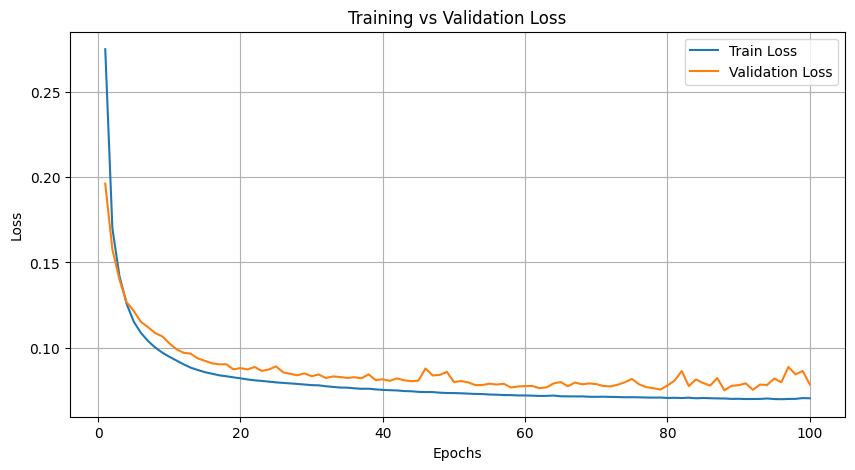

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


### Now evaluate it

In [12]:
model_file_path = 'graph_predictor_model.pth'
prediction_model: MyPredictionModel = load_model(model_file_path)

Again we evaluate on our metrics

In [13]:
instances = [(graph.get_parts(), graph) for graph in test_graphs]
evaluate_all_metrics(prediction_model, instances)

Processing graphs:   7%|▋         | 35/500 [00:01<00:14, 32.15graph/s, failed=0, P=0.8616, R=1.0000, F1=0.9204, Hamming=1.4324, Jaccard=0.8616, Edit Dist=1.4324, Acc=95.98%]

oups


Processing graphs:  58%|█████▊    | 291/500 [07:19<00:30,  6.89graph/s, failed=0, P=0.8591, R=0.9994, F1=0.9163, Hamming=1.7500, Jaccard=0.8588, Edit Dist=1.7432, Acc=95.66%] Exception ignored in: <generator object tqdm.__iter__ at 0x316928f20>
Traceback (most recent call last):
  File "/Users/anaconda3/envs/ai-project/lib/python3.8/site-packages/tqdm/std.py", line 1196, in __iter__
    self.close()
  File "/Users/anaconda3/envs/ai-project/lib/python3.8/site-packages/tqdm/std.py", line 1290, in close
    fp_write('')
  File "/Users/anaconda3/envs/ai-project/lib/python3.8/site-packages/tqdm/std.py", line 1287, in fp_write
    self.fp.write(str(s))
  File "/Users/anaconda3/envs/ai-project/lib/python3.8/site-packages/tqdm/utils.py", line 196, in inner
    return func(*args, **kwargs)
  File "/Users/anaconda3/envs/ai-project/lib/python3.8/site-packages/ipykernel/iostream.py", line 684, in write
    self._buffers[frozenset(parent.items())].write(string)
KeyboardInterrupt: 
Exception ignored

KeyboardInterrupt: 